In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import load_dataset, DatasetDict
from datasets import Dataset
import torch
from sklearn.preprocessing import LabelEncoder
import keras

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.14.0
Keras version: 2.14.0


# Model Implementation and Performance Analysis Notebook

This notebook serves as a comprehensive guide for analyzing and comparing the performance of different humor classification models across multimedia and natural text data. It provides an in-depth examination of binary and multifactorial classification approaches using two main architectures:

1. Fine-tuned BERT Models:
   - Binary classification (humor vs. non-humor)
   - Multifactorial classification (humor intensity levels 1-5)
   - Variants trained on different dataset sizes and captioning methods

2. LSTM-based Architectures:
   - Single-layer LSTM implementation
   - Dual-layer LSTM implementation
   - Both architectures combined with BERT embeddings

Each section includes:
- Model loading and configuration
- Performance evaluation metrics (accuracy, F1-score, recall)
- Comparative analysis between multimedia and natural text data
- Detailed error analysis and prediction samples

For implementation details and the complete steps to train these models yourself, please refer to the instructions provided in the README.md file. This notebook focuses on model evaluation and analysis rather than training, assuming pre-trained models are available.

Note: This notebook requires access to trained model checkpoints and the complete dataset with both multimedia and natural text samples.

In [3]:
def combine_dataframes(file_humour, file_no_humour, one_hot:bool = False):
    """
    Combine humor and non-humor datasets into a single dataset.
    
    Args:
        file_humour (str): Path to CSV file containing humor data
        file_no_humour (str): Path to CSV file containing non-humor data
        
    Returns:
        Dataset: Combined dataset with humor and non-humor examples
    """
    try:
        if one_hot:
            df_humor = pd.read_csv(file_humour)
            df_humor.rename(columns={"Chistes": "text"}, inplace=True)
            df_humor.drop(columns=["id_chiste"], inplace=True)
            
            # Create label encoder for nivel_risa
            label_encoder = LabelEncoder()
            df_humor['nivel_risa_encoded'] = label_encoder.fit_transform(df_humor['nivel_risa'])
            
            # Store the original mapping
            label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
            print("Label mapping:", label_mapping)
            
            dataset = Dataset.from_pandas(df_humor)
            return dataset, label_encoder
        else:
            df_no_humor = pd.read_csv(file_no_humour)
            df_no_humor["nivel_risa"] = 0
            
            df_humor = pd.read_csv(file_humour)
            df_humor.rename(columns={"Chistes": "text"}, inplace=True)
            df_humor['label'] = 1
            df_humor.drop(columns=["id_chiste"], inplace=True)
            
            df_combined = pd.concat([df_humor, df_no_humor], ignore_index=True)
            return Dataset.from_pandas(df_combined)
    except Exception as e:
        print(f"Error on combine_dataframes: {e}")

In [4]:
dataset = combine_dataframes("data/classification/complete_dataset_chistes.csv","data/classification/data_with_no_humour.csv")

In [5]:
dataset

Dataset({
    features: ['text', 'nivel_risa', 'label'],
    num_rows: 19417
})

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased',  unk_token="[UNK]")

def tokenize_function(examples, column: str ='label'):
    """
    Tokenizes text data and adds corresponding labels from a specified column.

    Args:
        examples (dict): Dictionary containing text samples to tokenize. Must have a 'text' key 
            containing the text to be tokenized.
        column (str, optional): Name of the column containing the labels. Defaults to 'label'.

    Returns:
        dict: Dictionary containing:
            - All tokenizer outputs (input_ids, attention_mask, etc.)
            - 'labels': List of labels copied from the specified column

    Notes:
        - Uses a global 'tokenizer' object which must be defined before calling this function
        - Truncates sequences to max_length=64 tokens
        - Uses padding='max_length' to pad all sequences to the same length
        
    Example:
        >>> data = {'text': ['sample text'], 'label': [1]}
        >>> tokenized = tokenize_function(data)
        >>> print(tokenized.keys())
        dict_keys(['input_ids', 'attention_mask', 'labels'])
    """
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=64
    )
    tokenized['labels'] = examples[column]  
    return tokenized

encoded_dataset = dataset.map(tokenize_function, batched=True)
vocab_size = tokenizer.vocab_size




Map:   0%|          | 0/19417 [00:00<?, ? examples/s]

In [7]:
vocab_size

28996

In [8]:
# Ver los tokens problemáticos
problematic_tokens = []
for i, tokens in enumerate(encoded_dataset['input_ids']):
    if max(tokens) >= vocab_size:
        problematic_tokens.append((i, max(tokens)))
        print(f"Ejemplo {i}, token problemático: {vocab_size}")

In [9]:
encoded_dataset

Dataset({
    features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 19417
})

In [10]:

train_validation_test_split = encoded_dataset.train_test_split(test_size=0.3, seed=42)

train_validation_split = train_validation_test_split['train'].train_test_split(test_size=0.1, seed=42)

final_split = DatasetDict({
    'train': train_validation_split['train'],  # 70% * 0.9 = 63% del total
    'validation': train_validation_split['test'],  # 70% * 0.1 = 7% del total
    'test': train_validation_test_split['test']  # 30% del total
})

# Revisar tamaños
print(final_split)


DatasetDict({
    train: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12231
    })
    validation: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1360
    })
    test: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5826
    })
})


In [115]:
test_df = pd.DataFrame({
    'text': final_split['test']['text'],
    'label': final_split['test']['labels']
})

# Save to CSV
test_df.to_csv('data/testing.csv', index=False)

In [11]:
final_split['train'].num_rows

12231

In [12]:
# Seleccionar una muestra aleatoria de 500 ejemplos para entrenamiento y 100 para validación
train_sample = final_split['train'].shuffle(seed=42).select(range(500))
validation_sample = final_split['validation'].shuffle(seed=42).select(range(100))

In [13]:
def sample_dataset(dataset, column, num_samples=20):
    """
    Creates a balanced sample of data by sampling an equal number of records from each category.

    Args:
        dataset (Union[Dataset, pd.DataFrame]): Input dataset, can be either a Hugging Face Dataset 
            or pandas DataFrame.
        column (str): Name of the column to stratify by (e.g., class labels).
        num_samples (int, optional): Number of samples to take from each unique value in the specified 
            column. Defaults to 20.

    Returns:
        pd.DataFrame: A new DataFrame containing the balanced sample with index reset.
        
    Notes:
        - Uses random_state=42 for reproducibility
        - If a category has fewer samples than requested, may raise ValueError
        - Automatically converts Hugging Face Dataset to pandas DataFrame if needed
        
    Example:
        >>> df = pd.DataFrame({'text': ['a', 'b', 'c', 'd'], 'label': [0, 0, 1, 1]})
        >>> balanced = sample_dataset(df, 'label', num_samples=1)
        >>> print(balanced)
           text  label
        0    a      0
        1    c      1
    """
    if isinstance(dataset, Dataset):
        df = dataset.to_pandas()
    else:
        df = dataset
    
    sampled_df = df.groupby(column).apply(lambda x: x.sample(n=num_samples, random_state=42))
    return sampled_df.reset_index(drop=True)

# Function to get predictions with proper tensor handling
def get_prediction(model, text):
    """
    Generates a single class prediction for a given text using a PyTorch model.

    Args:
        model: PyTorch model with a predict method that returns probabilities.
        text (str): Input text to classify.

    Returns:
        int: Predicted class index (argmax of model probabilities).

    Notes:
        - Disables gradient computation for inference efficiency
        - Assumes model.predict() returns a tensor of class probabilities
        - Automatically handles tensor-to-numpy conversion
        
    Example:
        >>> predicted_class = get_prediction(model, "sample text")
        >>> print(predicted_class)
        1
    """
    # Get prediction probabilities
    with torch.no_grad():  # Disable gradient tracking
        probs = model.predict(text)
        # Detach from computation graph and convert to numpy
        return probs.detach().numpy().argmax()

# Sample 20 rows per class
sampled_data = sample_dataset(dataset, column="label", num_samples=20)

# Extract texts and labels
texts = sampled_data["text"].tolist()
true_labels = sampled_data["label"].tolist()

C:\Users\acost\AppData\Local\Temp\ipykernel_43424\2023103589.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(column).apply(lambda x: x.sample(n=num_samples, random_state=42))


# Only Label - Binary

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred,binary:bool=True):
    """
    Compute evaluation metrics for model predictions.
    
    Args:
        eval_pred (tuple): Tuple of predictions and labels
        
    Returns:
        dict: Dictionary containing accuracy metric
    """
    try:
        if binary:
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            return {"accuracy": accuracy_score(labels, predictions)}
        else:
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            accuracy = accuracy_score(labels, predictions)
            
            label_encoder = LabelEncoder()
            
            # Convert numeric predictions back to original labels for better understanding
            pred_original = label_encoder.inverse_transform(predictions)
            labels_original = label_encoder.inverse_transform(labels)
            
            return {
                "accuracy": accuracy,
                "predictions": pred_original.tolist()[:5],  # Show first 5 predictions
                "true_labels": labels_original.tolist()[:5]  # Show first 5 true labels
            }
                
    except Exception as e:
            print(f"Error on compute_metrics: {e}")

## Fine tuning

In [15]:
from transformers import BertForSequenceClassification 


model = BertForSequenceClassification.from_pretrained('bert-large-cased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    learning_rate=5.0e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_steps=10,
    use_cpu = False,
    fp16=True,
    save_total_limit=1,
)


C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
tokenizer

BertTokenizer(name_or_path='bert-large-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_sample,      
    eval_dataset=validation_sample,  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  
)


### Modelo con captioning de GPT - 1000 data train

cargar el modelo 

In [19]:
from models.finetuning import FineTuning

# Initialize and load the model
model_1k_gpt_finetuning = FineTuning(num_labels=2)
model_path = r"models\binary\complete_dataset_chistes_finetuning_binary_model_1000_300"
model_1k_gpt_finetuning.load_model(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
predictions = [get_prediction(model_1k_gpt_finetuning, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Optional: Display predictions alongside texts
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

Confusion Matrix:
[[ 0 20]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: 1

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: 1

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: 1

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True Label: 0
Predicted: 1

Text: nada!--rugió el Capitán con suma

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

metrics evaluation on validation

In [22]:
# Path to the file
file_path = r"models\binary\evaluation\finetuning_bert_complete_dataset_chistes_1000_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6927055716514587
eval_accuracy: 0.5183823529411765
eval_f1_score: 0.6828087167070218
eval_f1_score_micro: 0.5183823529411765
eval_recall: 1.0
eval_runtime: 3.5107
eval_samples_per_second: 387.388
eval_steps_per_second: 48.423
epoch: 4.12



test evaluation

In [23]:
# Path to the file
file_path = r"models\binary\testing\finetuning_bert_binary_complete_dataset_chistes_1000_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6937559843063354
eval_accuracy: 0.5092687950566427
eval_f1_score: 0.6748549982940976
eval_f1_score_micro: 0.5092687950566427
eval_recall: 1.0
eval_runtime: 14.9526
eval_samples_per_second: 389.63
eval_steps_per_second: 48.754
epoch: 4.12



### Modelo con captioning de GPT - 5000 data train

In [24]:
from models.finetuning import FineTuning

# Initialize and load the model
model_5k_gpt_finetuning_binary = FineTuning(num_labels=2)
model_path = r"models\binary\complete_dataset_chistes_finetuning_binary_model_5000_300"
model_5k_gpt_finetuning_binary.load_model(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
predictions = [get_prediction(model_5k_gpt_finetuning_binary, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Optional: Display predictions alongside texts
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

Confusion Matrix:
[[20  0]
 [ 5 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.75      0.86        20

    accuracy                           0.88        40
   macro avg       0.90      0.88      0.87        40
weighted avg       0.90      0.88      0.87        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: 0

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: 0

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: 0

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True Label: 0
Predicted: 0

Text: nada!--rugió el Capitán con suma

metrics on validation

In [26]:
# Path to the file
file_path = r"models\binary\evaluation\finetuning_bert_complete_dataset_chistes_5000_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.35674652457237244
eval_accuracy: 0.8455882352941176
eval_f1_score: 0.825
eval_f1_score_micro: 0.8455882352941176
eval_recall: 0.7021276595744681
eval_runtime: 3.6226
eval_samples_per_second: 375.423
eval_steps_per_second: 46.928
epoch: 0.824



metrics on testing

In [27]:
# Path to the file
file_path = r"models\binary\testing\finetuning_bert_binary_complete_dataset_chistes_5000_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.3687657415866852
eval_accuracy: 0.8405423961551665
eval_f1_score: 0.8145338390896386
eval_f1_score_micro: 0.8405423961551665
eval_recall: 0.6875631951466128
eval_runtime: 14.7873
eval_samples_per_second: 393.987
eval_steps_per_second: 49.299
epoch: 0.824



### Modelo con captioning de GPT - All data train

In [28]:
from models.finetuning import FineTuning

# Initialize and load the model
model_12k_gpt_finetuning = FineTuning(num_labels=2)
model_path = r"models\binary\complete_dataset_chistes_finetuning_binary_model_12231_300"
model_12k_gpt_finetuning.load_model(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
predictions = [get_prediction(model_12k_gpt_finetuning, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Optional: Display predictions alongside texts
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

Confusion Matrix:
[[20  0]
 [20  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: 0

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: 0

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: 0

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True Label: 0
Predicted: 0

Text: nada!--rugió el Capitán con suma

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

metrics on validation

In [30]:
# Path to the file
file_path = r"models\binary\evaluation\finetuning_bert_complete_dataset_chistes_12231_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6962682604789734
eval_accuracy: 0.48161764705882354
eval_f1_score: 0.0
eval_f1_score_micro: 0.48161764705882354
eval_recall: 0.0
eval_runtime: 3.2242
eval_samples_per_second: 421.809
eval_steps_per_second: 52.726
epoch: 0.6638325703073904



metrics on testing

In [31]:
# Path to the file
file_path = r"models\binary\testing\finetuning_bert_binary_complete_dataset_chistes_12231_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6953372359275818
eval_accuracy: 0.49073120494335737
eval_f1_score: 0.0
eval_f1_score_micro: 0.49073120494335737
eval_recall: 0.0
eval_runtime: 13.7737
eval_samples_per_second: 422.981
eval_steps_per_second: 52.927
epoch: 0.6638325703073904



### Modelo con captioning de blip - All data train

In [32]:
from models.finetuning import FineTuning

# Initialize and load the model
model_12k_blip_finetuning_binary = FineTuning(num_labels=2)
model_path = r"models\binary\captionning_blip_finetuning_binary_model_12225_300"
model_12k_blip_finetuning_binary.load_model(model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
predictions = [get_prediction(model_12k_blip_finetuning_binary, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Optional: Display predictions alongside texts
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

Confusion Matrix:
[[ 0 20]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: 1

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: 1

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: 1

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True Label: 0
Predicted: 1

Text: nada!--rugió el Capitán con suma

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

metrics on evaluation

In [34]:
# Path to the file
file_path = r"models\binary\evaluation\finetuning_bert_captionning_blip_12225_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6977542638778687
eval_accuracy: 0.4952170713760118
eval_f1_score: 0.6624015748031497
eval_f1_score_micro: 0.4952170713760118
eval_recall: 1.0
eval_runtime: 3.7709
eval_samples_per_second: 360.39
eval_steps_per_second: 45.082
epoch: 0.3368214519293656



metrics on testing

In [35]:
# Path to the file
file_path = r"models\binary\testing\finetuning_bert_binary_captionning_blip_12225_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (binary):
--------------------------------------------------
eval_loss: 0.6942014098167419
eval_accuracy: 0.5145997938852628
eval_f1_score: 0.6795191653436153
eval_f1_score_micro: 0.5145997938852628
eval_recall: 1.0
eval_runtime: 16.1916
eval_samples_per_second: 359.568
eval_steps_per_second: 44.961
epoch: 0.3368214519293656



# LSTM

In [36]:
def get_prediction_lstm(classifier, text: str):
    """
    Generates binary predictions for text using a BERT-tokenized LSTM classifier.
    
    Args:
        classifier: LSTM classifier with encode_data and predict methods.
                   Must accept BERT tokenized inputs and return probabilities.
        text (str): Raw text input to classify.
    
    Returns:
        int: Binary prediction (0 or 1) based on 0.5 threshold.
    
    Notes:
        - Uses bert-large-cased tokenizer
        - Truncates/pads sequences to 64 tokens
        - Returns numpy array format with a dummy label
        - Assumes classifier.encode_data() returns tuple of (input_ids, attention_mask, token_type_ids)
        - Assumes classifier.predict() returns probability scores
        
    Workflow:
        1. Tokenizes input text using BERT tokenizer
        2. Formats tokens into required structure with dummy label
        3. Encodes data using classifier's encode_data method
        4. Gets probability predictions
        5. Applies 0.5 threshold to get binary prediction
        
    Example:
        >>> prediction = get_prediction_lstm(lstm_classifier, "Sample text to classify")
        >>> print(prediction)  # Prints 0 or 1
        1
    """

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
    
    # Tokenize the text
    tokens = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=64,
        return_tensors='np'
    )
    
    # Create properly formatted input
    single_item = [{
        'input_ids': tokens['input_ids'][0],
        'attention_mask': tokens['attention_mask'][0],
        'token_type_ids': tokens['token_type_ids'][0],
        'labels': 0  # dummy label
    }]
    
    # Get encoded input and predictions
    encoded_input = classifier.encode_data(single_item)
    probs = classifier.predict(encoded_input[0], encoded_input[1], encoded_input[2])
    
    return (probs > 0.5).astype(int)[0]

In [37]:
import tensorflow
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score
from datasets import DatasetDict
import numpy as np

In [38]:
tokenizer

BertTokenizer(name_or_path='bert-large-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [39]:
encoded_dataset 

Dataset({
    features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 19417
})

In [40]:
train_sample_1 = final_split['train']
train_sample_1

Dataset({
    features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 12231
})

In [41]:
validation_sample_1 = final_split['validation']
validation_sample_1

Dataset({
    features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1360
})

In [42]:
from transformers import TFBertModel
import tensorflow as tf
import keras

In [43]:
bert_model = TFBertModel.from_pretrained('bert-large-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## ARCHITECTURE 1 - LSTM 2 One Layer

In [44]:

from keras.models import load_model
from models.encoder_only_lstm import LSTM_1Classifier, LSTM_2Classifier
from keras.utils import custom_object_scope

# Initialize classifier
classifier_lstm2_binary = LSTM_2Classifier(bert_path='bert-large-cased', max_length=64)

# Get the custom BertLayer class
BertLayer = classifier_lstm2_binary.BertLayer

# Load the model with custom_object_scope
with custom_object_scope({'BertLayer': BertLayer}):
    classifier_lstm2_binary.model = load_model('models/binary/lstm2_model.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [45]:
# Make predictions
predictions = [get_prediction_lstm(classifier_lstm2_binary, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Display sample predictions
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

1/1 [==============================] - 0s 340ms/step
Confusion Matrix:
[[20  0]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: [0]

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: [0]

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: [0]

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True La

In [46]:
# Path to the file
file_path = r"models\binary\testing\lstm2_binary_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for lstm2 (binary):
--------------------------------------------------
Accuracy: 0.9895
F1 Score: 0.9897
Recall: 0.9862

Debug Information:
Unique predicted classes: [0 1]
Unique true labels: [0 1]
Number of samples: 5826

Class Distribution:
Predicted positives: 2946
Predicted negatives: 2880
Actual positives: 2967
Actual negatives: 2859



In [47]:
classifier_lstm2_binary.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                              

In [48]:
# Path to the file
file_path = r"models\binary\evaluation\lstm2_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Final Validation Results for lstm2 (binary):
--------------------------------------------------
Accuracy: 0.9934
F1 Score: 0.9936
Recall: 0.9929

Debug Information:
Number of validation samples: 1360
Unique predicted classes: [0 1]
Unique true labels: [0 1]

Class Distribution:
Predicted positives: 704
Predicted negatives: 656
Actual positives: 705
Actual negatives: 655



## Architecture 2 - LSTM 1 Two layer

In [49]:
# Initialize classifier
classifier_lstm1_binary = LSTM_1Classifier(bert_path='bert-large-cased', max_length=64)

# Get the custom BertLayer class
BertLayer = classifier_lstm1_binary.BertLayer

# Load the model with custom_object_scope
with custom_object_scope({'BertLayer': BertLayer}):
    classifier_lstm1_binary.model = load_model('models/binary/lstm1_model.h5')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [50]:

# Make predictions
predictions = [get_prediction_lstm(classifier_lstm1_binary, text) for text in texts]

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Display sample predictions
print("\nSample Predictions:")
for text, true_label, pred in zip(texts[:5], true_labels[:5], predictions[:5]):
    print(f"\nText: {text[:100]}...")  # Show first 100 chars
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred}")

1/1 [==============================] - 0s 364ms/step
Confusion Matrix:
[[20  0]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Sample Predictions:

Text: para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enferme...
True Label: 0
Predicted: [0]

Text: Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la cas...
True Label: 0
Predicted: [0]

Text: ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa...
True Label: 0
Predicted: [0]

Text: Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto qu...
True La

results on testing

In [51]:
# Path to the file
file_path = r"models\binary\testing\lstm1_binary_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)




Test Set Evaluation Results for lstm1 (binary):
--------------------------------------------------
Accuracy: 0.9827
F1 Score: 0.9827
Recall: 0.9690

Debug Information:
Unique predicted classes: [0 1]
Unique true labels: [0 1]
Number of samples: 5826

Class Distribution:
Predicted positives: 2884
Predicted negatives: 2942
Actual positives: 2967
Actual negatives: 2859



results on evaluation

In [52]:
# Path to the file
file_path = r"models\binary\evaluation\lstm1_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Final Validation Results for lstm1 (binary):
--------------------------------------------------
Accuracy: 0.9926
F1 Score: 0.9929
Recall: 0.9872

Debug Information:
Number of validation samples: 1360
Unique predicted classes: [0 1]
Unique true labels: [0 1]

Class Distribution:
Predicted positives: 697
Predicted negatives: 663
Actual positives: 705
Actual negatives: 655



In [103]:
classifier_lstm1_binary.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                              

## Multifactorial

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Function to sample 20 rows per class
def sample_dataset(dataset, column, num_samples=20):
    """
    Creates a balanced dataset by sampling an equal number of rows from each class category.
    
    Args:
        dataset (Union[Dataset, pd.DataFrame]): Input dataset, can be either a Hugging Face Dataset 
            or pandas DataFrame.
        column (str): Name of the column containing class labels to stratify by.
        num_samples (int, optional): Number of samples to draw from each unique class. 
            Defaults to 20.
    
    Returns:
        pd.DataFrame: A balanced DataFrame containing the sampled data with:
            - Equal number of samples per class
            - Reset index
            - All original columns preserved
    
    Notes:
        - Uses random_state=42 for reproducible sampling
        - If a class has fewer samples than num_samples, will raise ValueError
        - Automatically converts Hugging Face Dataset to pandas DataFrame if needed
        - Returns a new DataFrame; does not modify the input dataset
    
    Example:
        >>> # For binary classification
        >>> data = pd.DataFrame({'text': ['a', 'b', 'c', 'd'], 'label': [0, 0, 1, 1]})
        >>> balanced = sample_dataset(data, column='label', num_samples=1)
        >>> print(balanced['label'].value_counts())
        0    1
        1    1
    """
    # Convert Dataset to a pandas DataFrame if necessary
    if isinstance(dataset, Dataset):
        df = dataset.to_pandas()
    else:
        df = dataset

    sampled_df = df.groupby(column).apply(lambda x: x.sample(n=num_samples, random_state=42))
    return sampled_df.reset_index(drop=True)

# Sample 20 rows per class
sampled_data = sample_dataset(dataset, column="nivel_risa", num_samples=20)

# Extract texts and labels
texts = sampled_data["text"].tolist()  # Assuming the column with text data is 'text'
true_labels = sampled_data["nivel_risa"].tolist()

C:\Users\acost\AppData\Local\Temp\ipykernel_43424\2212130348.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(column).apply(lambda x: x.sample(n=num_samples, random_state=42))


In [123]:
sampled_data

,text,nivel_risa,nivel_risa_encoded
0,No hay vuelta que darle dijo el que dormia en ...,4,3
1,La que me gusta se ha quitado la foto de perfi...,4,3
2,Que haces cuando ves un negro desangrarse en l...,4,3
3,El profesor de la materia de relleno: De mañan...,4,3
4,"Imagen de Bob Esponja vestido como un ganster,...",4,3
...,...,...,...
95,¿Qué le dice una pizza a otra pizza en Año Nue...,1,0
96,¿Qué hace un esquiador cuando quiere contar un...,1,0
97,¿Cuál es el animal más rápido en el atletismo?...,1,0
98,- ¿Qué hace un sombrero en una clase de histor...,1,0


In [121]:
sampled_data.to_csv("data/balanced_sample_multifactorial.csv")

In [54]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from datasets import load_dataset, DatasetDict
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [55]:

dataset, label_encoder = combine_dataframes(
    "data/classification/complete_dataset_chistes.csv",
    "data/classification/data_with_no_humour.csv",one_hot=True
)


Label mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [56]:
train_validation_test_split = encoded_dataset.train_test_split(test_size=0.3, seed=42)
train_validation_split = train_validation_test_split['train'].train_test_split(test_size=0.1, seed=42)

final_split = DatasetDict({
    'train': train_validation_split['train'],
    'validation': train_validation_split['test'],
    'test': train_validation_test_split['test']
})

In [57]:
final_split

DatasetDict({
    train: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12231
    })
    validation: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1360
    })
    test: Dataset({
        features: ['text', 'nivel_risa', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5826
    })
})

In [58]:
train_sample = final_split['train'].shuffle(seed=42).select(range(500))
validation_sample = final_split['validation'].shuffle(seed=42).select(range(100))


In [59]:
encoded_dataset = dataset.map(
    lambda x: tokenize_function(x, column='nivel_risa_encoded'), 
    batched=True
)

Map:   0%|          | 0/9933 [00:00<?, ? examples/s]

In [60]:
num_labels = len(label_encoder.classes_)
print(f"Number of nivel_risa categories: {num_labels}")

Number of nivel_risa categories: 5


In [61]:
model = BertForSequenceClassification.from_pretrained(
    'bert-large-cased', 
    num_labels=num_labels  # Set number of labels to match nivel_risa categories
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Finetuning

In [62]:
def compute_metrics_multifactorial(binary:bool=True, encoder=None):
    """
    Compute evaluation metrics for model predictions.
    
    Args:
        binary (bool): Whether to compute metrics for binary classification
        encoder: LabelEncoder instance for non-binary classification
        
    Returns:
        dict: Dictionary containing metrics
    """
    def compute(eval_pred):
        try:
            if binary:
                predictions, labels = eval_pred
                predictions = np.argmax(predictions, axis=1)
                return {"accuracy": accuracy_score(labels, predictions)}
            else:
                predictions, labels = eval_pred
                predictions = np.argmax(predictions, axis=1)
                accuracy = accuracy_score(labels, predictions)
                
                # Use the passed encoder
                pred_original = encoder.inverse_transform(predictions)
                labels_original = encoder.inverse_transform(labels)
                
                # Convert lists to strings to avoid TensorBoard warning
                pred_examples = ','.join(map(str, pred_original[:5]))
                label_examples = ','.join(map(str, labels_original[:5]))
                
                return {
                    "accuracy": accuracy,
                    "predictions_sample": pred_examples,  # Now a string
                    "true_labels_sample": label_examples,  # Now a string
                    # Add some additional scalar metrics
                    "pred_mean": predictions.mean(),
                    "pred_std": predictions.std(),
                }
                    
        except Exception as e:
                print(f"Error on compute_metrics: {e}")
    
    return compute

In [63]:


training_args = TrainingArguments(
    output_dir='./finetuning_multifactorial_model',
    evaluation_strategy="steps",
    learning_rate=5.0e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_steps=10,
    use_cpu=False,
    fp16=True,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_sample,
    eval_dataset=validation_sample,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_multifactorial(encoder=label_encoder),  
)



C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [64]:
texts

['para María de la Piedad una existencia de abandonada. De repente, todo en torno de ella --la enfermedad del marido, achaques de los hijos, tristezas de sus días, la costura--',
 'Hospital General y un cesante, a quien llamaban don Cleto. Don Cleto Meana era el filósofo de la casa, era un hombre bien educado y culto, que había caído en',
 'ví hecho minero, Mas nunca tuvo el pobre mina buena: Busquemos una agora en otro canto, Que ya cansa decir en este tanto. CANTO SEXTO. _Viene Obispo al Paraguay. Muere',
 'Una mano blanca y fría, blanca como la nieve y como la nieve fría, tocó su mano. Y sintió Augusto que se derramaba por su ser todo como un fluido',
 'nada!--rugió el Capitán con suma nobleza.--¡Pues no faltaba más, estando yo en el mundo![290]--Cierto es que el pobre Álvaro...--yo no quiero quitarle su mérito,--en cuanto supo[291] la fatal ocurrencia se',
 'aquí estuvieres, pídelo; que por este buen servicio que me has hecho, se hará por ti. Yo, como no esperaba tal ganancia, llen

### Model trained with 1000 data

In [65]:
from models.finetuning import MultifactorialFineTuning

# Initialize the class (you'll need to specify num_labels)
model_1k_gpt = MultifactorialFineTuning(num_labels=6)  # Since it's a multifactorial model with 6 classes

# Load the saved model
model_path = "models/multifactorial/complete_dataset_chistes_finetuning_multifactorial_model_1000_300"
model_1k_gpt.load_model(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
predictions = [np.argmax(model_1k_gpt.predict(text)) for text in texts]

conf_matrix = confusion_matrix(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Confusion Matrix:
[[20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120



C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

results on evaluation

In [67]:
# Path to the file
file_path = r"models\multifactorial\evaluation\finetuning_bert_complete_dataset_chistes_1000_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.3677188158035278
eval_accuracy: 0.48161764705882354
eval_f1_score: 0.3131112246387389
eval_f1_score_micro: 0.48161764705882354
eval_recall: 0.48161764705882354
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 0,0,3,3,0
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 3.281
eval_samples_per_second: 414.504
eval_steps_per_second: 51.813
epoch: 4.12



results on test


In [68]:
# Path to the file
file_path = r"models\multifactorial\testing\finetuning_bert_multifactorial_complete_dataset_chistes_1000_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Test Set Evaluation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.3475522994995117
eval_accuracy: 0.49073120494335737
eval_f1_score: 0.32308589866046256
eval_f1_score_micro: 0.49073120494335737
eval_recall: 0.49073120494335737
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 2,0,1,0,3
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 14.0747
eval_samples_per_second: 413.934
eval_steps_per_second: 51.795
epoch: 4.12



### Model trained with 5000 data

In [69]:
from models.finetuning import MultifactorialFineTuning

# Initialize the class (you'll need to specify num_labels)
model_5k_gpt = MultifactorialFineTuning(num_labels=6)  # Since it's a multifactorial model with 6 classes

# Load the saved model
model_path = "models/multifactorial/complete_dataset_chistes_finetuning_multifactorial_model_5000_300"
model_5k_gpt.load_model(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
predictions = [np.argmax(model_5k_gpt.predict(text)) for text in texts]

conf_matrix = confusion_matrix(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Confusion Matrix:
[[20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120



C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

results on evaluation

In [71]:
# Path to the file
file_path = r"models\multifactorial\evaluation\finetuning_bert_complete_dataset_chistes_5000_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.3914062976837158
eval_accuracy: 0.48161764705882354
eval_f1_score: 0.3131112246387389
eval_f1_score_micro: 0.48161764705882354
eval_recall: 0.48161764705882354
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 0,0,3,3,0
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 3.2542
eval_samples_per_second: 417.925
eval_steps_per_second: 52.241
epoch: 1.032



results on testing

In [72]:


# Path to the file
file_path = r"models\multifactorial\testing\finetuning_bert_multifactorial_complete_dataset_chistes_5000_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Test Set Evaluation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.369434118270874
eval_accuracy: 0.49073120494335737
eval_f1_score: 0.32308589866046256
eval_f1_score_micro: 0.49073120494335737
eval_recall: 0.49073120494335737
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 2,0,1,0,3
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 13.874
eval_samples_per_second: 419.922
eval_steps_per_second: 52.544
epoch: 1.032



### Model trained with the whole train dataset

In [73]:
from models.finetuning import MultifactorialFineTuning

# Initialize the class (you'll need to specify num_labels)
model_12k_gpt_finetuning_multifactorial = MultifactorialFineTuning(num_labels=6)  # Since it's a multifactorial model with 6 classes

# Load the saved model
model_path = "models/multifactorial/complete_dataset_chistes_finetuning_multifactorial_model_12231_300"
model_12k_gpt_finetuning_multifactorial.load_model(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
predictions = [np.argmax(model_12k_gpt_finetuning_multifactorial.predict(text)) for text in texts]

conf_matrix = confusion_matrix(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Confusion Matrix:
[[20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120



C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

results on evaluation

In [75]:
# Path to the file
file_path = r"models\multifactorial\evaluation\finetuning_bert_complete_dataset_chistes_12231_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 0.8678938746452332
eval_accuracy: 0.5911764705882353
eval_f1_score: 0.512193443974577
eval_f1_score_micro: 0.5911764705882353
eval_recall: 0.5911764705882353
eval_predictions_sample: 0,0,3,3,0
eval_true_labels_sample: 0,0,3,3,0
eval_pred_mean: 1.5198529411764705
eval_pred_std: 1.4998686144881637
eval_runtime: 3.2495
eval_samples_per_second: 418.53
eval_steps_per_second: 52.316
epoch: 0.3368214519293656



results on test

In [76]:
# Path to the file
file_path = r"models\multifactorial\testing\finetuning_bert_multifactorial_complete_dataset_chistes_12231_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 0.8716588020324707
eval_accuracy: 0.6071060762100927
eval_f1_score: 0.5261256894074561
eval_f1_score_micro: 0.6071060762100927
eval_recall: 0.6071060762100927
eval_predictions_sample: 3,0,3,0,3
eval_true_labels_sample: 2,0,1,0,3
eval_pred_mean: 1.4871266735324409
eval_pred_std: 1.4999447581379988
eval_runtime: 13.9483
eval_samples_per_second: 417.686
eval_steps_per_second: 52.264
epoch: 0.3368214519293656



# Finetuning captioning

In [77]:
from models.finetuning import MultifactorialFineTuning

# Initialize the class (you'll need to specify num_labels)
model_12k_VIT_finetuning_multifactorial = MultifactorialFineTuning(num_labels=6)  # Since it's a multifactorial model with 6 classes

# Load the saved model
model_path = "models/multifactorial/captionning_vlt_finetuning_multifactorial_model_12225_300"
model_12k_VIT_finetuning_multifactorial.load_model(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
predictions = [np.argmax(model_12k_VIT_finetuning_multifactorial.predict(text)) for text in texts]

conf_matrix = confusion_matrix(true_labels, predictions)

# Display results
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Confusion Matrix:
[[20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]
 [20  0  0  0  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        20

    accuracy                           0.17       120
   macro avg       0.03      0.17      0.05       120
weighted avg       0.03      0.17      0.05       120



C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

results on evaluation

In [79]:
# Path to the file
file_path = r"models\multifactorial\evaluation\finetuning_bert_captionning_vlt_12225_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.3453768491744995
eval_accuracy: 0.5047829286239882
eval_f1_score: 0.33866121177120384
eval_f1_score_micro: 0.5047829286239882
eval_recall: 0.5047829286239882
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 2,2,0,0,2
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 3.5247
eval_samples_per_second: 385.561
eval_steps_per_second: 48.231
epoch: 0.3368214519293656



results on test

In [80]:
# Path to the file
file_path = r"models\multifactorial\testing\finetuning_bert_multifactorial_captionning_vlt_12225_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Test Set Evaluation Results for finetuning_bert (multifactorial):
--------------------------------------------------
eval_loss: 1.366455316543579
eval_accuracy: 0.4854002061147372
eval_f1_score: 0.31723889511569087
eval_f1_score_micro: 0.4854002061147372
eval_recall: 0.4854002061147372
eval_predictions_sample: 0,0,0,0,0
eval_true_labels_sample: 0,2,1,0,3
eval_pred_mean: 0.0
eval_pred_std: 0.0
eval_runtime: 15.037
eval_samples_per_second: 387.178
eval_steps_per_second: 48.414
epoch: 0.3368214519293656



In [81]:
def get_prediction_lstm_multifactorial(classifier, text):
    """
    Get predictions for multifactorial classification
    
    Args:
        classifier: The trained classifier model
        text: Input text to classify
        
    Returns:
        int: Predicted class (0-5)
    """
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
    
    # Tokenize the text
    tokens = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=64,
        return_tensors='np'
    )
    
    # Create properly formatted input
    single_item = [{
        'input_ids': tokens['input_ids'][0],
        'attention_mask': tokens['attention_mask'][0],
        'token_type_ids': tokens['token_type_ids'][0],
        # For multifactorial, we use nivel_risa_encoded instead of labels
        'nivel_risa_encoded': 0  # dummy label, will be ignored for prediction
    }]
    
    # Get inputs only, ignore the encoded labels
    input_ids = np.array([item['input_ids'] for item in single_item])
    attention_mask = np.array([item['attention_mask'] for item in single_item])
    token_type_ids = np.array([item['token_type_ids'] for item in single_item])
    
    # Make prediction
    probs = classifier.predict(input_ids, attention_mask, token_type_ids)
    
    # Return class with highest probability
    return np.argmax(probs[0])

In [82]:
def sample_dataset(dataset, num_samples=20):
    """
    Sample equal number of instances from each class, handling empty classes
    
    Args:
        dataset: Input dataset
        num_samples: Number of samples per class (default=20)
        
    Returns:
        pd.DataFrame: Sampled dataset with equal class distribution
    """
    # Convert Dataset to DataFrame if necessary
    if not isinstance(dataset, pd.DataFrame):
        df = pd.DataFrame(dataset)
    else:
        df = dataset
    
    # First check which classes are present
    present_classes = df['nivel_risa'].unique()
    print(f"Classes present in dataset: {sorted(present_classes)}")
    print(f"Class distribution:\n{df['nivel_risa'].value_counts().sort_index()}")
    
    # Sample from each present class
    sampled_dfs = []
    for class_label in present_classes:
        class_data = df[df['nivel_risa'] == class_label]
        n_available = len(class_data)
        
        if n_available == 0:
            print(f"Warning: No samples found for class {class_label}")
            continue
            
        if n_available >= num_samples:
            sampled_class = class_data.sample(n=num_samples, random_state=42)
        else:
            print(f"Warning: Only {n_available} samples available for class {class_label}, sampling with replacement")
            sampled_class = class_data.sample(n=num_samples, replace=True, random_state=42)
        
        sampled_dfs.append(sampled_class)
    
    if not sampled_dfs:
        raise ValueError("No valid samples found in any class")
    
    # Combine all sampled data
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\nFinal sampled distribution:\n{sampled_df['nivel_risa'].value_counts().sort_index()}")
    
    return sampled_df


In [83]:
def evaluate_predictions(classifier, sampled_data):
    """
    Evaluate classifier performance on sampled data
    
    Args:
        classifier: Trained classifier model
        sampled_data: DataFrame with sampled data
        
    Returns:
        tuple: (confusion_matrix, classification_report, sample_predictions)
    """
    texts = sampled_data['text'].tolist()
    true_labels = sampled_data['nivel_risa'].tolist()
    
    # Get predictions
    predictions = []
    for i, text in enumerate(texts):
        try:
            pred = get_prediction_lstm_multifactorial(classifier, text)
            predictions.append(pred)
            if i < 5:  # Print first few predictions for debugging
                print(f"\nPrediction {i+1}:")
                print(f"Text: {text[:100]}...")
                print(f"True label: {true_labels[i]}")
                print(f"Predicted: {pred}")
        except Exception as e:
            print(f"Error predicting text: {text[:100]}...")
            print(f"Error details: {str(e)}")
            continue
    
    if not predictions:
        raise ValueError("No valid predictions were made")
    
    # Calculate metrics
    conf_matrix = confusion_matrix(true_labels[:len(predictions)], predictions)
    class_report = classification_report(true_labels[:len(predictions)], predictions)
    
    # Get sample predictions for display
    sample_preds = []
    for i in range(min(5, len(predictions))):
        sample_preds.append({
            'text': texts[i][:100],
            'true_label': true_labels[i],
            'predicted': predictions[i]
        })
    
    return conf_matrix, class_report, sample_preds

In [84]:

class BaseClassifier:
    def __init__(self, bert_path='bert-large-cased', max_length=64, multifactorial= False):
        """
        Base class for BERT-based classification models.
        
        Provides common functionality for model initialization, data encoding,
        training, prediction, and evaluation. Serves as parent class for specific
        classifier implementations.
        
        Attributes:
            bert_path (str): Path to pre-trained BERT model
            max_length (int): Maximum sequence length for input texts
            model: The Keras model instance
            multifactorial (bool): Whether model handles multiple classes
        """
        self.bert_path = bert_path
        self.max_length = max_length
        self.model = None
        self.multifactorial = multifactorial
        
    class BertLayer(keras.layers.Layer):
        """
        Custom Keras layer wrapping BERT model.
        
        Creates a non-trainable BERT layer that outputs the last hidden states
        of the model for use in downstream tasks.
        
        Args:
            bert_path (str): Path to pre-trained BERT model
            **kwargs: Additional arguments passed to parent Layer class
        """
        def __init__(self, bert_path='bert-large-cased', **kwargs):
            super().__init__(**kwargs)
            # Specify output_hidden_states=True to get all hidden states
            self.bert = TFBertModel.from_pretrained(bert_path, output_hidden_states=True)
            self.bert.trainable = False
            
        def call(self, inputs):
            input_ids, attention_mask, token_type_ids = inputs
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,                
            )
            # Use the last hidden state instead of pooler output
            return outputs.last_hidden_state
    
    def build_model(self):
        """
        Abstract method to define model architecture.
        
        Must be implemented by subclasses to create their specific model architectures.
        
        Raises:
            NotImplementedError: If subclass doesn't implement this method
        """
        raise NotImplementedError("Subclasses must implement build_model")
    
    def encode_data(self, dataset):
        """
        Encode input data for model processing.
        
        Args:
            dataset: Dataset containing input_ids, attention_mask, token_type_ids, and labels
            
        Returns:
            tuple: For binary classification:
                - input_ids (np.array)
                - attention_mask (np.array)
                - token_type_ids (np.array)
                - labels (np.array)
            For multifactorial:
                - Same as above but labels are one-hot encoded for 6 categories
        """
        if self.multifactorial:
            input_ids = np.array([item["input_ids"] for item in dataset])
            attention_mask = np.array([item["attention_mask"] for item in dataset])
            token_type_ids = np.array([item["token_type_ids"] for item in dataset])
            # Get labels and convert to one-hot encoding
            labels = np.array([item["nivel_risa_encoded"] for item in dataset])
            # Convert to one-hot encoding for 6 categories (0-5)
            one_hot_labels = np.eye(6)[labels]
            return input_ids, attention_mask, token_type_ids, one_hot_labels
        
        else:
            input_ids = np.array([item["input_ids"] for item in dataset])
            attention_mask = np.array([item["attention_mask"] for item in dataset])
            token_type_ids = np.array([item["token_type_ids"] for item in dataset])
            labels = np.array([item["labels"] for item in dataset])
            return input_ids, attention_mask, token_type_ids, labels
    
    def train(self, train_dataset, validation_dataset, epochs=10, batch_size=16, patience=3):
        """
        Train the model on provided datasets.
        
        Args:
            train_dataset: Training data
            validation_dataset: Validation data
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            patience (int): Early stopping patience
            
        Returns:
            keras.callbacks.History: Training history
        """
        train_inputs = self.encode_data(train_dataset)
        val_inputs = self.encode_data(validation_dataset)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=patience, restore_best_weights=True, mode='min'
        )
        history = self.model.fit(
            x=[train_inputs[0], train_inputs[1], train_inputs[2]],
            y=train_inputs[3],
            validation_data=( [val_inputs[0], val_inputs[1], val_inputs[2]], val_inputs[3] ),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping]
        )
        return history
    
    def predict(self, input_ids, attention_mask, token_type_ids):
        """
        Make predictions using the trained model.
        
        Args:
            input_ids: BERT input token IDs
            attention_mask: BERT attention mask
            token_type_ids: BERT token type IDs
            
        Returns:
            np.array: Model predictions
        """
        return self.model.predict([input_ids, attention_mask, token_type_ids])
    
    def evaluate(self, test_dataset):
        """
        Evaluate model performance on test dataset.
        
        Args:
            test_dataset: Test data to evaluate on
            
        Returns:
            dict: Evaluation metrics (loss and accuracy)
        """
        test_inputs = self.encode_data(test_dataset)
        results = self.model.evaluate(
            [test_inputs[0], test_inputs[1], test_inputs[2]],
            test_inputs[3]
        )
        return dict(zip(self.model.metrics_names, results))

# LSTM 1 AND LSTM 2

In [85]:
class LSTM_2_MultiFactorial(BaseClassifier):
    """
    Multi-class classifier combining BERT with single bidirectional LSTM layer.
    
    Architecture:
        1. BERT layer for text encoding
        2. Self-attention layer
        3. Concatenation of BERT output and attention
        4. Single bidirectional LSTM
        5. Six unit softmax output for multi-class classification
    """
    
    def build_model(self):
        """
        Creates a multi-class classification model combining BERT with single LSTM layer.
        
        Architecture:
            1. Input layers:
                - input_ids: Token indices of input sequence (shape: [batch_size, 64])
                - attention_mask: Mask for padding (shape: [batch_size, 64])
                - token_type_ids: Segment tokens (shape: [batch_size, 64])
            
            2. BERT Layer:
                - Non-trainable BERT-large-cased model
                - Outputs last hidden states
            
            3. Attention mechanism:
                - Self-attention on BERT outputs
                - Helps focus on relevant parts of input
            
            4. Feature combination:
                - Concatenates BERT outputs with attention outputs
                - Enriches representation with attention information
            
            5. LSTM layer:
                - Single Bidirectional LSTM with 256 units
                - Returns final sequence state
                - Total 512 features (256 * 2 directions)
            
            6. Output:
                - Dense layer with 6 units (one per class)
                - Softmax activation for multi-class classification
        
        Returns:
            keras.Model: Compiled model with inputs [input_ids, attention_mask, token_type_ids]
                        and multi-class classification output (6 classes)
        """
        input_ids = keras.layers.Input(shape=(64,), dtype='int32', name='input_ids')
        attention_mask = keras.layers.Input(shape=(64,), dtype='int32', name='attention_mask')
        token_type_ids = keras.layers.Input(shape=(64,), dtype='int32', name='token_type_ids')
        
        bert_layer = self.BertLayer(self.bert_path)
        sequence_output = bert_layer([input_ids, attention_mask, token_type_ids])
        
        attention = keras.layers.Attention()([sequence_output, sequence_output])
        
        merge_layer = keras.layers.Concatenate()([sequence_output, attention])
        
        LSTM1_layer = keras.layers.Bidirectional(
            keras.layers.LSTM(units=256)
        )(merge_layer)
            
        output_layer = keras.layers.Dense(units=6, activation='softmax')(LSTM1_layer)
        
        self.model = keras.Model(
            inputs=[input_ids, attention_mask, token_type_ids],
            outputs=output_layer
        )
        return self.model
    
    
class LSTM_1_MultiFactorial(BaseClassifier):
    """
    Multi-class classifier combining BERT with dual bidirectional LSTM layers.
    
    Architecture:
        1. BERT layer for text encoding
        2. Self-attention layer
        3. Concatenation of BERT output and attention
        4. First bidirectional LSTM with sequence return
        5. Dropout layer
        6. Second bidirectional LSTM
        7. Six unit softmax output for multi-class classification
    """
    
    def build_model(self):
        """
        Creates a multi-class classification model combining BERT with dual LSTM layers.
        
        Architecture:
            1. Input layers:
                - input_ids: Token indices of input sequence (shape: [batch_size, 64])
                - attention_mask: Mask for padding (shape: [batch_size, 64])
                - token_type_ids: Segment tokens (shape: [batch_size, 64])
            
            2. BERT Layer:
                - Non-trainable BERT-large-cased model
                - Outputs last hidden states
            
            3. Attention mechanism:
                - Self-attention on BERT outputs
                - Helps focus on relevant parts of input
            
            4. Feature combination:
                - Concatenates BERT outputs with attention outputs
                - Enriches representation with attention information
            
            5. First LSTM layer:
                - Bidirectional LSTM with 256 units
                - Returns sequences for hierarchical processing
                - Total 512 features (256 * 2 directions)
            
            6. Regularization:
                - Dropout layer with 0.3 rate
                - Prevents overfitting
            
            7. Second LSTM layer:
                - Bidirectional LSTM with 256 units
                - Returns final sequence state
                - Total 512 features (256 * 2 directions)
            
            8. Output:
                - Dense layer with 6 units (one per class)
                - Softmax activation for multi-class classification
        
        Returns:
            keras.Model: Compiled model with inputs [input_ids, attention_mask, token_type_ids]
                        and multi-class classification output (6 classes)
        """
        input_ids = keras.layers.Input(shape=(64,), dtype='int32', name='input_ids')
        attention_mask = keras.layers.Input(shape=(64,), dtype='int32', name='attention_mask')
        token_type_ids = keras.layers.Input(shape=(64,), dtype='int32', name='token_type_ids')
        
        bert_layer = self.BertLayer(self.bert_path)
        sequence_output = bert_layer([input_ids, attention_mask, token_type_ids])
        
        attention = keras.layers.Attention()([sequence_output, sequence_output])
        
        merge_layer = keras.layers.Concatenate()([sequence_output, attention])
        
        LSTM1_layer = keras.layers.Bidirectional(
            keras.layers.LSTM(units=256, return_sequences=True)
        )(merge_layer)
        
        dropout_layer = keras.layers.Dropout(rate=0.3)(LSTM1_layer)
        
        LSTM2_layer = keras.layers.Bidirectional(
            keras.layers.LSTM(units=256)
        )(dropout_layer)
        
        output_layer = keras.layers.Dense(units=6, activation='softmax')(LSTM2_layer)
        
        self.model = keras.Model(
            inputs=[input_ids, attention_mask, token_type_ids],
            outputs=output_layer
        )
        return self.model

In [86]:
# Initialize classifier

from models.encoder_only_lstm import LSTM_2_MultiFactorial, LSTM_1_MultiFactorial

classifier_lstm2_multifactorial = LSTM_2_MultiFactorial(bert_path='bert-large-cased', max_length=64)

# Get the custom BertLayer class
BertLayer = classifier_lstm2_multifactorial.BertLayer

# Load the model with custom_object_scope
with custom_object_scope({'BertLayer': BertLayer}):
    classifier_lstm2_multifactorial.model = load_model('models/multifactorial/lstm2_model.h5')
    

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [87]:
classifier_lstm2_multifactorial.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                            

In [88]:
try:
    # Sample dataset
    print("\nSampling dataset...")
    sampled_data = sample_dataset(dataset, num_samples=20)
    
    print("\nMaking predictions...")
    # Evaluate predictions
    conf_matrix, class_report, sample_preds = evaluate_predictions(classifier_lstm2_multifactorial, sampled_data)
    
    # Display results
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
        
except Exception as e:
    print(f"Error during execution: {str(e)}")
    import traceback
    traceback.print_exc()


Sampling dataset...
Classes present in dataset: [1, 2, 3, 4, 5]
Class distribution:
nivel_risa
1    1216
2    4627
3    2897
4     988
5     205
Name: count, dtype: int64

Final sampled distribution:
nivel_risa
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64

Making predictions...
1/1 [==============================] - 8s 8s/step

Prediction 1:
Text: No hay vuelta que darle dijo el que dormia en un muro...
True label: 4
Predicted: 2
1/1 [==============================] - 1s 503ms/step

Prediction 2:
Text: La que me gusta se ha quitado la foto de perfil y no le llegan los mensajes, creo que le gusto...
True label: 4
Predicted: 4
1/1 [==============================] - 0s 477ms/step

Prediction 3:
Text: Que haces cuando ves un negro desangrarse en la calle? Dejar de reír y pegarle otro tiro....
True label: 4
Predicted: 2
1/1 [==============================] - 0s 453ms/step

Prediction 4:
Text: El profesor de la materia de relleno: De mañana un informe de lecturs del pdf

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

In [89]:
# Path to the file
file_path = r"models\multifactorial\evaluation\lstm2_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for lstm2 (multifactorial):
--------------------------------------------------
Accuracy: 0.7294
F1 Score: 0.6718
Recall: 0.7294

Debug Information:
Number of validation samples: 1360
Unique predicted classes: [0 1 2 3 4]
Unique true labels: [0 1 2 3 4 5]

Class Distribution:
Predicted class counts:
Class 0: 663
Class 1: 1
Class 2: 611
Class 3: 78
Class 4: 7

True class counts:
Class 0: 655
Class 1: 92
Class 2: 334
Class 3: 192
Class 4: 74
Class 5: 13



In [90]:
# Path to the file
file_path = r"models\multifactorial\testing\lstm2_multifactorial_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Test Set Evaluation Results for lstm2 (multifactorial):
--------------------------------------------------
Accuracy: 0.7259
F1 Score: 0.6722
Recall: 0.7259

Debug Information:
Unique predicted classes: [0 1 2 3 4]
Unique true labels: [0 1 2 3 4 5]
Number of samples: 5826



In [91]:
classifier_lstm1_multifactorial = LSTM_1_MultiFactorial(bert_path='bert-large-cased', max_length=64)

# Get the custom BertLayer class
BertLayer = classifier_lstm1_multifactorial.BertLayer

# Load the model with custom_object_scope
with custom_object_scope({'BertLayer': BertLayer}):
    classifier_lstm1_multifactorial.model = load_model('models/multifactorial/lstm1_model.h5')
    

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [92]:
classifier_lstm1_multifactorial.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                            

In [93]:
try:
    # Sample dataset
    print("\nSampling dataset...")
    sampled_data = sample_dataset(dataset, num_samples=20)
    
    print("\nMaking predictions...")
    # Evaluate predictions
    conf_matrix, class_report, sample_preds = evaluate_predictions(classifier_lstm1_multifactorial, sampled_data)
    
    # Display results
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
        
except Exception as e:
    print(f"Error during execution: {str(e)}")
    import traceback
    traceback.print_exc()


Sampling dataset...
Classes present in dataset: [1, 2, 3, 4, 5]
Class distribution:
nivel_risa
1    1216
2    4627
3    2897
4     988
5     205
Name: count, dtype: int64

Final sampled distribution:
nivel_risa
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64

Making predictions...
1/1 [==============================] - 8s 8s/step

Prediction 1:
Text: No hay vuelta que darle dijo el que dormia en un muro...
True label: 4
Predicted: 2
1/1 [==============================] - 0s 457ms/step

Prediction 2:
Text: La que me gusta se ha quitado la foto de perfil y no le llegan los mensajes, creo que le gusto...
True label: 4
Predicted: 4
1/1 [==============================] - 0s 434ms/step

Prediction 3:
Text: Que haces cuando ves un negro desangrarse en la calle? Dejar de reír y pegarle otro tiro....
True label: 4
Predicted: 4
1/1 [==============================] - 0s 416ms/step

Prediction 4:
Text: El profesor de la materia de relleno: De mañana un informe de lecturs del pdf

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

evaluation on validation

In [94]:
# Path to the file
file_path = r"models\multifactorial\evaluation\lstm1_validation_results.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)


Final Validation Results for lstm1 (multifactorial):
--------------------------------------------------
Accuracy: 0.7309
F1 Score: 0.6804
Recall: 0.7309

Debug Information:
Number of validation samples: 1360
Unique predicted classes: [0 1 2 3 4]
Unique true labels: [0 1 2 3 4 5]

Class Distribution:
Predicted class counts:
Class 0: 665
Class 1: 25
Class 2: 596
Class 3: 37
Class 4: 37

True class counts:
Class 0: 655
Class 1: 92
Class 2: 334
Class 3: 192
Class 4: 74
Class 5: 13



evaluation on testing

In [95]:
# Path to the file
file_path = r"models\multifactorial\testing\lstm1_multifactorial_test_evaluation.txt"

# Open the file and read its contents
with open(file_path, 'r') as file:
    content = file.read()

# Display the content in the notebook cell
print(content)

Test Set Evaluation Results for lstm1 (multifactorial):
--------------------------------------------------
Accuracy: 0.7245
F1 Score: 0.6699
Recall: 0.7245

Debug Information:
Unique predicted classes: [0 1 2 3 4]
Unique true labels: [0 1 2 3 4 5]
Number of samples: 5826



# TEXT VS MULTIMEDIA TEXT

We are keeping the best model of finetuning captioning which would be the one with GPT meaning that for the binary it would be the one from 5000 data and for the multifactorial the one with all data, the other models we are using are the 2 encoder only classifiers with LSTMs layers.


In [96]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from typing import Dict, List, Tuple, Any
import random

In [97]:

def sample_stratified_data(dataset: Dataset, 
                          start_idx: int, 
                          end_idx: int, 
                          samples_per_category: int = 20,
                          is_multifactorial: bool = False) -> Dataset:
    """
    Creates a stratified sample of data from a specific index range, ensuring balanced representation 
    across categories.

    Args:
        dataset (Dataset): Input Hugging Face dataset to sample from.
        start_idx (int): Starting index of the range to sample from.
        end_idx (int): Ending index (exclusive) of the range to sample from.
        samples_per_category (int, optional): Number of samples to select from each category. 
            Defaults to 20.
        is_multifactorial (bool, optional): If True, samples from categories 1-5. If False, samples 
            from binary categories 0-1. Defaults to False.

    Returns:
        Dataset: A new Hugging Face Dataset containing:
            - For binary (is_multifactorial=False): 40 total samples (20 each from categories 0,1)
            - For multifactorial (is_multifactorial=True): 100 total samples (20 each from 
              categories 1-5)

    Notes:
        - Expects 'nivel_risa' as the category column name
        - Prints detailed sampling statistics during execution
        - Uses sampling with replacement if a category has fewer samples than requested
        - Only samples from categories that are present in the specified index range
        - For binary classification, target categories are [0,1]
        - For multifactorial classification, target categories are [1,2,3,4,5]

    Example:
        >>> # Binary classification example
        >>> binary_sample = sample_stratified_data(dataset, 0, 1000, samples_per_category=20)
        >>> print(len(binary_sample))  # Should print 40 (20 samples × 2 categories)
        
        >>> # Multifactorial classification example
        >>> multi_sample = sample_stratified_data(dataset, 0, 1000, samples_per_category=20, 
        ...                                       is_multifactorial=True)
        >>> print(len(multi_sample))  # Should print 100 (20 samples × 5 categories)
    """
    subset = dataset.select(range(start_idx, end_idx))
    
    # Check what categories are present in the data
    all_labels = [item['nivel_risa'] for item in subset]
    unique_labels = sorted(set(all_labels))
    print(f"Categories present in range {start_idx}-{end_idx}: {unique_labels}")
    
    # For binary classification (0,1) or multifactorial (1-5)
    if is_multifactorial:
        target_categories = [cat for cat in range(1, 6) if cat in unique_labels]
    else:
        target_categories = [cat for cat in [0, 1] if cat in unique_labels]
    
    sampled_data = []
    for category in target_categories:
        category_data = [i for i, item in enumerate(subset) if item['nivel_risa'] == category]
        n_available = len(category_data)
        
        print(f"Category {category}: {n_available} samples available")
        
        if n_available > 0:
            if n_available >= samples_per_category:
                selected_indices = random.sample(category_data, samples_per_category)
            else:
                print(f"Warning: Only {n_available} samples available for category {category}, sampling with replacement")
                selected_indices = random.choices(category_data, k=samples_per_category)
            sampled_data.extend([subset[i] for i in selected_indices])
    
    result_dataset = Dataset.from_list(sampled_data)
    
    # Print distribution of samples
    final_distribution = {}
    for item in result_dataset:
        category = item['nivel_risa']
        final_distribution[category] = final_distribution.get(category, 0) + 1
    
    print("\nFinal sample distribution:")
    for category in sorted(final_distribution.keys()):
        print(f"Category {category}: {final_distribution[category]} samples")
    print(f"Total samples: {len(result_dataset)}")
    
    return result_dataset

In [98]:
def predict_text(model, text, is_multifactorial=False, model_type='finetuning'):
    """
    Generates predictions for a single text input using either a fine-tuned or LSTM model.

    Args:
        model: Trained model object that implements a predict method.
            - For finetuning: Must return probabilities or predicted labels
            - For LSTM: Must be compatible with get_prediction_lstm functions
        text (str): Input text to classify.
        is_multifactorial (bool, optional): If True, performs multi-class classification (1-5).
            If False, performs binary classification (0-1). Defaults to False.
        model_type (str, optional): Type of model to use. Must be either 'finetuning' or 'lstm'.
            Defaults to 'finetuning'.

    Returns:
        Union[int, None]: 
            - For binary classification: 0 or 1
            - For multifactorial: Integer from 1-5
            - None if prediction fails
    
    Raises:
        Exception: Catches and logs any prediction errors, returning None instead of failing.

    Notes:
        - For finetuning models:
            - Binary: Returns 1 if probability > 0.5, else 0
            - Multifactorial: Returns predicted label directly
        - For LSTM models:
            - Uses separate prediction functions for binary and multifactorial cases
        - Truncates error messages for long texts to first 100 characters
        
    Example:
        >>> # Binary classification with fine-tuned model
        >>> result = predict_text(model, "Sample text", is_multifactorial=False)
        >>> print(result)  # Prints 0 or 1
        
        >>> # Multifactorial classification with LSTM model
        >>> result = predict_text(model, "Sample text", is_multifactorial=True, model_type='lstm')
        >>> print(result)  # Prints 1-5
    """
    try:
        if model_type == 'finetuning':
            if is_multifactorial:
                result = model.predict(text)
                return result['predicted_label']
            else:
                probs = model.predict(text)
                return int(probs[0][1] > 0.5)
        else:  # LSTM
            if is_multifactorial:
                return get_prediction_lstm_multifactorial(model, text)
            else:
                return get_prediction_lstm(model, text)
    except Exception as e:
        print(f"Error predicting text: {text[:100]}...")
        print(f"Error details: {str(e)}")
        return None

In [99]:
def evaluate_model(model, data, is_multifactorial=False, model_type='finetuning'):
    """
    Evaluates model performance on a dataset by computing accuracy, F1-score, and recall metrics.

    Args:
       model: Trained model object that implements prediction functionality. Should be compatible
           with predict_text() function.
       data (List[Dict]): List of dictionaries containing text samples and labels. Each dict must
           have 'text' and 'nivel_risa' keys.
       is_multifactorial (bool, optional): If True, performs multi-class evaluation (classes 1-5).
           If False, performs binary evaluation (0-1). Defaults to False.
       model_type (str, optional): Type of model to evaluate - either 'finetuning' or 'lstm'.
           Defaults to 'finetuning'.

    Returns:
       Dict[str, float]: Dictionary containing evaluation metrics:
           - 'accuracy': Overall classification accuracy
           - 'f1_score': F1-score (weighted average for multi-class)
           - 'recall': Recall score (weighted average for multi-class) 
           - 'n_samples': Number of successfully processed samples

    Raises:
       ValueError: If no valid predictions could be made on the input data.

    Notes:
       - Handles failed predictions gracefully by skipping them
       - Uses weighted averaging for multi-class metrics to handle class imbalance
       - Sets zero_division=0 for F1 and recall calculations to handle edge cases
       - Truncates true labels if some predictions fail
       - Prints progress and final metrics to stdout
       
    Example:
       >>> test_data = [{'text': 'sample text', 'nivel_risa': 1}, ...]
       >>> metrics = evaluate_model(model, test_data, is_multifactorial=True)
       >>> print(f"Accuracy: {metrics['accuracy']:.4f}")
    """
    texts = [item['text'] for item in data]
    true_labels = [item['nivel_risa'] for item in data]
    predictions = []
    
    print(f"Evaluating {len(texts)} samples...")
    
    for text in texts:
        pred = predict_text(model, text, is_multifactorial, model_type)
        if pred is not None:
            predictions.append(pred)
    
    if not predictions:
        raise ValueError("No valid predictions were made")
    
    # Truncate true_labels to match predictions length
    true_labels = true_labels[:len(predictions)]
    
    if is_multifactorial:
        # Use weighted average for multiclass metrics to handle class imbalance
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    else:
        f1 = f1_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
    
    accuracy = accuracy_score(true_labels, predictions)
    
    print(f"Processed {len(predictions)} predictions out of {len(texts)} samples")
    print(f"Metrics - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}")
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'n_samples': len(predictions)
    }

In [100]:
def compare_models_performance(dataset, models):
    """
    Compares multiple models' performance on multimedia and natural text data splits by evaluating
    their accuracy, F1-score, and recall metrics.

    Args:
        dataset (Dataset): Hugging Face dataset containing text samples and labels.
        models (Dict[str, Tuple]): Dictionary mapping model names to tuples containing:
            - model: The trained model object
            - is_multifactorial (bool): Whether model does multi-class classification
            - model_type (str): Type of model ('finetuning' or 'lstm')
            Example format: {
                'model_name': (model_object, is_multifactorial, model_type)
            }

    Returns:
        pd.DataFrame: DataFrame containing evaluation results with columns:
            - model: Name of the model
            - data_type: Either 'multimedia' (indices 0-2006) or 'natural_text' (indices 2007+)
            - accuracy: Classification accuracy
            - f1_score: F1 score 
            - recall: Recall score
            - n_samples: Number of samples evaluated

    Notes:
        - Splits data into two parts:
            - Multimedia: First 2006 samples
            - Natural text: Remaining samples (2007 onwards)
        - Uses stratified sampling to get 20 samples per category from each split
        - Handles errors independently for each model and data split
        - Prints progress and error information during execution
        - Missing results from failed evaluations will not appear in output DataFrame

    Example:
        >>> models_dict = {
        ...     'BERT': (bert_model, False, 'finetuning'),
        ...     'LSTM': (lstm_model, True, 'lstm')
        ... }
        >>> results_df = compare_models_performance(dataset, models_dict)
        >>> print(results_df.groupby(['model', 'data_type'])['accuracy'].mean())
    """
    results = []
    total_samples = len(dataset)
    print(f"Total dataset size: {total_samples}")
    
    for model_name, (model, is_multifactorial, model_type) in models.items():
        print(f"\nEvaluating {model_name}...")
        
        try:
            print("\nSampling multimedia data (0-2006)...")
            multimedia_data = sample_stratified_data(dataset, 0, 2006, 20, is_multifactorial)
            multimedia_metrics = evaluate_model(model, multimedia_data, is_multifactorial, model_type)
            results.append({
                'model': model_name,
                'data_type': 'multimedia',
                **multimedia_metrics
            })
        except Exception as e:
            print(f"Error evaluating {model_name} on multimedia data: {str(e)}")
        
        try:
            print("\nSampling natural text data (2007-end)...")
            natural_text_data = sample_stratified_data(dataset, 2007, total_samples, 20, is_multifactorial)
            natural_metrics = evaluate_model(model, natural_text_data, is_multifactorial, model_type)
            results.append({
                'model': model_name,
                'data_type': 'natural_text',
                **natural_metrics
            })
        except Exception as e:
            print(f"Error evaluating {model_name} on natural text data: {str(e)}")
    
    return pd.DataFrame(results)

In [101]:
models = {
    'GPT Binary': (model_5k_gpt_finetuning_binary, False, 'finetuning'),
    'LSTM2 Binary': (classifier_lstm2_binary, False, 'lstm'),
    'LSTM1 Binary': (classifier_lstm1_binary, False, 'lstm'),
    'GPT Multifactorial': (model_12k_gpt_finetuning_multifactorial, True, 'finetuning'),
    'LSTM2 Multifactorial': (classifier_lstm2_multifactorial, True, 'lstm'),
    'LSTM1 Multifactorial': (classifier_lstm1_multifactorial, True, 'lstm')
}

# Run comparison
results_df = compare_models_performance(dataset, models)

# Display results with better formatting
print("\nResults:")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(results_df)
# Show detailed summary statistics
print("\nSummary by model type and data type:")
summary = results_df.groupby(['model', 'data_type']).agg({
    'accuracy': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'n_samples': ['mean', 'min', 'max']
}).round(4)
print(summary)

Total dataset size: 9933

Evaluating GPT Binary...

Sampling multimedia data (0-2006)...
Categories present in range 0-2006: [1, 2, 3, 4, 5]
Category 1: 286 samples available

Final sample distribution:
Category 1: 20 samples
Total samples: 20
Evaluating 20 samples...
Processed 20 predictions out of 20 samples
Metrics - Accuracy: 0.7000, F1: 0.8235, Recall: 0.7000

Sampling natural text data (2007-end)...
Categories present in range 2007-9933: [1, 2, 3, 4, 5]
Category 1: 930 samples available

Final sample distribution:
Category 1: 20 samples
Total samples: 20
Evaluating 20 samples...
Processed 20 predictions out of 20 samples
Metrics - Accuracy: 0.9500, F1: 0.9744, Recall: 0.9500

Evaluating LSTM2 Binary...

Sampling multimedia data (0-2006)...
Categories present in range 0-2006: [1, 2, 3, 4, 5]
Category 1: 286 samples available

Final sample distribution:
Category 1: 20 samples
Total samples: 20
Evaluating 20 samples...
1/1 [==============================] - 0s 424ms/step
Processed 2

In [102]:
results_df

,model,data_type,accuracy,f1_score,recall,n_samples
0,GPT Binary,multimedia,0.7000,0.8235,0.7000,20
1,GPT Binary,natural_text,0.9500,0.9744,0.9500,20
2,LSTM2 Binary,multimedia,1.0000,1.0000,1.0000,20
3,LSTM2 Binary,natural_text,1.0000,1.0000,1.0000,20
4,LSTM1 Binary,multimedia,1.0000,1.0000,1.0000,20
5,LSTM1 Binary,natural_text,1.0000,1.0000,1.0000,20
6,GPT Multifactorial,multimedia,0.2000,0.0721,0.2000,100
7,GPT Multifactorial,natural_text,0.1800,0.0621,0.1800,100
8,LSTM2 Multifactorial,multimedia,0.2300,0.1275,0.2300,100
9,LSTM2 Multifactorial,natural_text,0.2600,0.1866,0.2600,100


## Propmts Results LLM ChatGPT vs Our Model

In [116]:
df = pd.read_csv("data/testing.csv")
df

,text,label
0,Mi hermana siempre me consuela. Debe ser porqu...,1
1,los platos y platitos forman una estrella. Los...,0
2,¿Qué pinta un pintor cuando se aburre? Abstrac...,1
3,del presupuesto _del cielo_. Entónces es cuand...,0
4,"Mismo joven rubio de la imagen anterior, pero ...",1
...,...,...
5821,Estaba en un restaurante y mientras iba al bañ...,1
5822,"corriendo, dando brincos increibles y vueltas ...",0
5823,con buenos parques de artillería y fuertes res...,0
5824,y por esta causa me afligía más que de antes. ...,0


In [117]:
from sklearn.utils import resample


In [119]:
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Calculate the number of samples per class for balance (10 samples each)
n_samples = 20

# Randomly sample from each class
class_0_sampled = resample(class_0, n_samples=n_samples, random_state=42)
class_1_sampled = resample(class_1, n_samples=n_samples, random_state=42)

# Combine sampled data
balanced_sample = pd.concat([class_0_sampled, class_1_sampled])

# Shuffle the resulting dataframe
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the selected samples
print(balanced_sample)

balanced_sample.to_csv("data/balanced_sample.csv", index=False)


                                                 text  label
0   en ella más de la cuenta. Esto se iba murmuran...      0
1   un bravo sir Rogerio, que batalló en compañía ...      0
2   familia; rostro enjuto, nariz aguileña, aspect...      0
3   Una pregunta para todos los racistas, de verda...      1
4   por muerto a don Martín, cogió los cuartos del...      0
5   todo. FÁBULA XVI. _SIRINGA TRANSFORMADA EN CAÑ...      0
6    ¿Cuál es la diferencia entre un bebé y una bo...      1
7   como te gustan los hombres ? Yo: lejos y callados      1
8   Yo esperando que sean las 5pm para ver el part...      1
9   casa y reino de nuestros padres, y esta nuestr...      0
10   ¿Sabes por qué los niños con cáncer no pueden...      1
11  le di por los pechos, y así los despaché a tod...      0
12  miraban y alababan, pero ningún rey, ni otro a...      0
13   ¿Cómo se llama el mejor amigo de un robot? ¡USB!      1
14   ¿Por qué la modelo fitness se hizo un tatuaje...      1
15  ninguna sobre los de


Evaluating GPT Binary...

Evaluating LSTM2 Binary...
1/1 [==============================] - 0s 416ms/step

Evaluating LSTM1 Binary...
1/1 [==============================] - 0s 343ms/step

Evaluating GPT Multifactorial...


C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15


Evaluating LSTM2 Multifactorial...
1/1 [==============================] - 0s 350ms/step

Evaluating LSTM1 Multifactorial...


C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

1/1 [==============================] - 0s 421ms/step

Binary Classification Results:

GPT Binary
----------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.70      0.82        20

    accuracy                           0.85        40
   macro avg       0.88      0.85      0.85        40
weighted avg       0.88      0.85      0.85        40


LSTM2 Binary
------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


LSTM1 Binary
------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy        

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

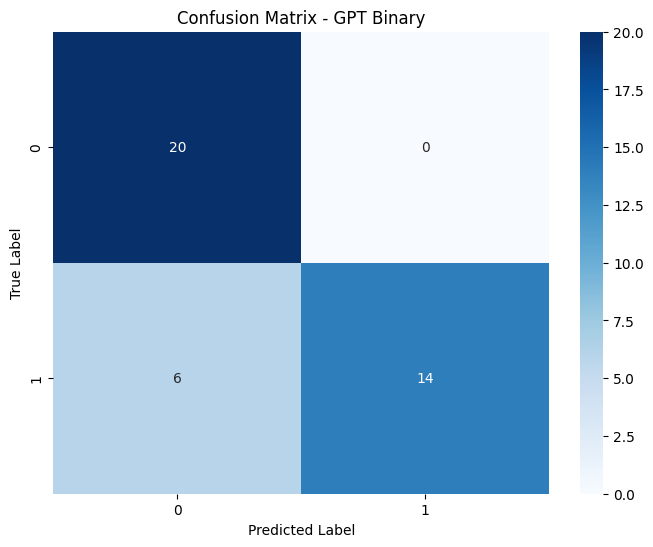

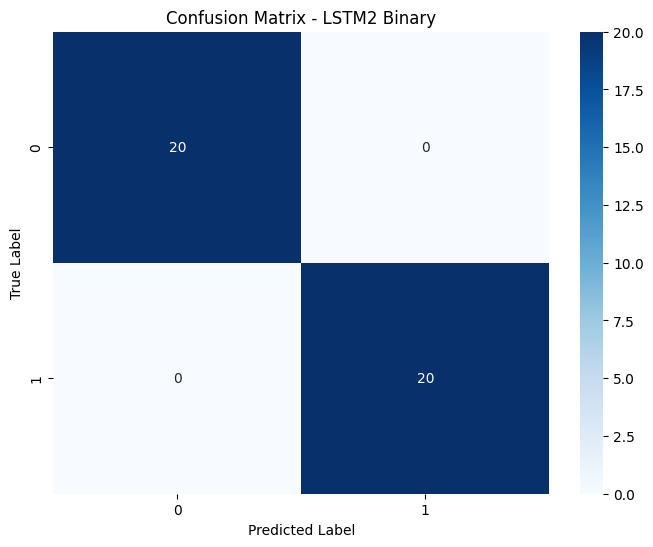

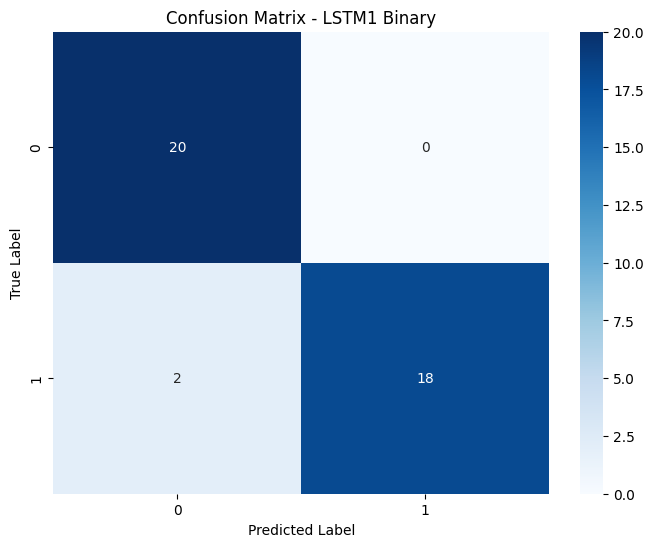

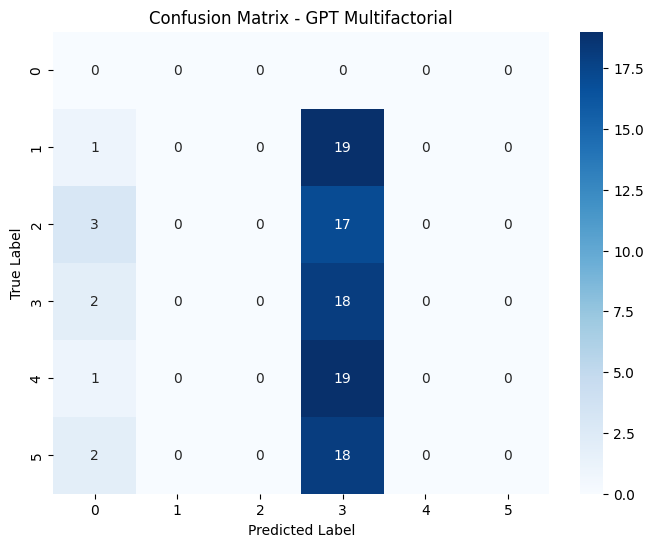

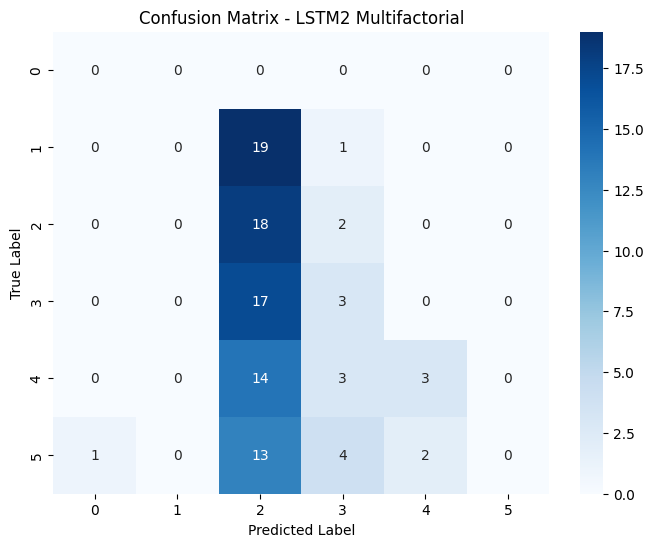

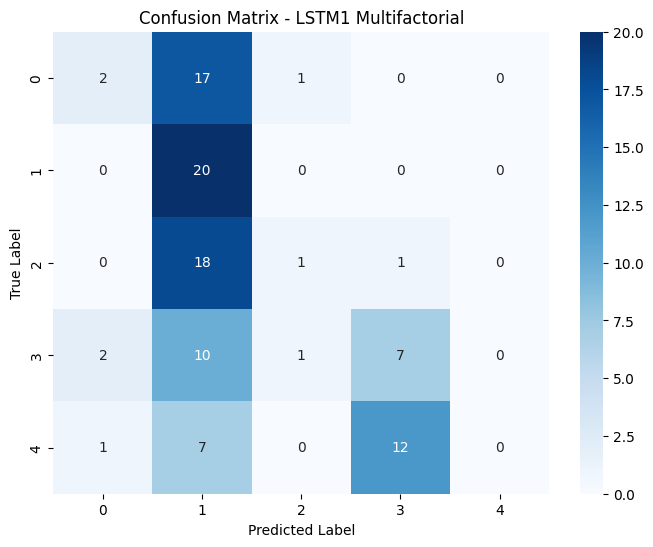

In [124]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_binary_models(df, models):
    """
    Evaluate binary classification models on the balanced sample
    """
    results = {}
    
    for model_name, (model, is_multi, model_type) in models.items():
        if not is_multi:  # Only evaluate binary models
            print(f"\nEvaluating {model_name}...")
            predictions = []
            
            for text in df['text']:
                if model_type == 'finetuning':
                    pred = int(model.predict(text)[0][1] > 0.5)
                else:  # lstm
                    pred = get_prediction_lstm(model, text)
                predictions.append(pred)
            
            results[model_name] = {
                'predictions': predictions,
                'report': classification_report(df['label'], predictions),
                'confusion_matrix': confusion_matrix(df['label'], predictions)
            }
    
    return results

def evaluate_multifactorial_models(df, models):
    """
    Evaluate multifactorial classification models on the balanced sample
    """
    results = {}
    
    for model_name, (model, is_multi, model_type) in models.items():
        if is_multi:  # Only evaluate multifactorial models
            print(f"\nEvaluating {model_name}...")
            predictions = []
            
            for text in df['text']:
                if model_type == 'finetuning':
                    pred = model.predict(text)['predicted_label']
                else:  # lstm
                    pred = get_prediction_lstm_multifactorial(model, text)
                predictions.append(pred)
            
            results[model_name] = {
                'predictions': predictions,
                'report': classification_report(df['nivel_risa'], predictions),
                'confusion_matrix': confusion_matrix(df['nivel_risa'], predictions)
            }
    
    return results

# Load the balanced datasets
binary_df = pd.read_csv("data/balanced_sample.csv")
multi_df = pd.read_csv("data/balanced_sample_multifactorial.csv")

# Define models dictionary (as provided)
models = {
    'GPT Binary': (model_5k_gpt_finetuning_binary, False, 'finetuning'),
    'LSTM2 Binary': (classifier_lstm2_binary, False, 'lstm'),
    'LSTM1 Binary': (classifier_lstm1_binary, False, 'lstm'),
    'GPT Multifactorial': (model_12k_gpt_finetuning_multifactorial, True, 'finetuning'),
    'LSTM2 Multifactorial': (classifier_lstm2_multifactorial, True, 'lstm'),
    'LSTM1 Multifactorial': (classifier_lstm1_multifactorial, True, 'lstm')
}

# Evaluate models
binary_results = evaluate_binary_models(binary_df, models)
multi_results = evaluate_multifactorial_models(multi_df, models)

# Print results
print("\nBinary Classification Results:")
print("==============================")
for model_name, result in binary_results.items():
    print(f"\n{model_name}")
    print("-" * len(model_name))
    print(result['report'])

print("\nMultifactorial Classification Results:")
print("====================================")
for model_name, result in multi_results.items():
    print(f"\n{model_name}")
    print("-" * len(model_name))
    print(result['report'])

# Create confusion matrix visualizations
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

for model_name, result in binary_results.items():
    plot_confusion_matrix(result['confusion_matrix'], f'Confusion Matrix - {model_name}')

for model_name, result in multi_results.items():
    plot_confusion_matrix(result['confusion_matrix'], f'Confusion Matrix - {model_name}')



In [127]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

def calculate_metrics(y_true, y_pred, is_multifactorial=False):
    """
    Calculate performance metrics ensuring consistent lengths
    """
    # Convert inputs to lists and ensure same length
    y_true = list(y_true)
    y_pred = list(y_pred)
    
    # Verify we have valid data
    if len(y_true) != len(y_pred):
        print(f"Warning: Inconsistent lengths - y_true: {len(y_true)}, y_pred: {len(y_pred)}")
        # Take the minimum length to ensure consistency
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
    
    # Remove any invalid entries (like NaN)
    valid_indices = [i for i in range(len(y_true)) 
                    if pd.notna(y_true[i]) and pd.notna(y_pred[i])]
    y_true = [y_true[i] for i in valid_indices]
    y_pred = [y_pred[i] for i in valid_indices]
    
    if is_multifactorial:
        f1 = f1_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
    else:
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'n_samples': len(y_true)
    }

def print_detailed_results(y_true, y_pred, task_name):
    """
    Print detailed classification report
    """
    print(f"\n{task_name} Classification Report:")
    print("-" * 50)
    print(classification_report(y_true, y_pred))


In [128]:

# Load datasets
binary_original = pd.read_csv("data/balanced_sample.csv")
binary_gpt = pd.read_csv("data/balanced_sample_gpt_answers.csv")
multi_original = pd.read_csv("data/balanced_sample_multifactorial.csv")

multi_gpt = pd.read_csv("data/balanced_sample_multifactorial_gpt_answers.csv")

# Clean data to ensure valid comparisons
def clean_data(df):
    """Remove any rows with NaN values"""
    return df.dropna()

binary_original = clean_data(binary_original)
binary_gpt = clean_data(binary_gpt)
multi_original = clean_data(multi_original)
multi_gpt = clean_data(multi_gpt)

# Ensure matching indices
binary_indices = binary_original.index.intersection(binary_gpt.index)
multi_indices = multi_original.index.intersection(multi_gpt.index)

# Calculate metrics for binary classification
binary_metrics = calculate_metrics(
    binary_original.loc[binary_indices, 'label'],
    binary_gpt.loc[binary_indices, 'label']
)

# Calculate metrics for multifactorial classification
multi_metrics = calculate_metrics(
    multi_original.loc[multi_indices, 'nivel_risa'],
    multi_gpt.loc[multi_indices, 'nivel_risa'],
    is_multifactorial=True
)

# Print results
print("\nBinary Classification Metrics:")
print("============================")
print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
print(f"F1-Score: {binary_metrics['f1_score']:.4f}")
print(f"Recall: {binary_metrics['recall']:.4f}")
print(f"Number of samples: {binary_metrics['n_samples']}")

print("\nMultifactorial Classification Metrics:")
print("================================")
print(f"Accuracy: {multi_metrics['accuracy']:.4f}")
print(f"F1-Score: {multi_metrics['f1_score']:.4f}")
print(f"Recall: {multi_metrics['recall']:.4f}")
print(f"Number of samples: {multi_metrics['n_samples']}")

# Print detailed classification reports
print_detailed_results(
    binary_original.loc[binary_indices, 'label'],
    binary_gpt.loc[binary_indices, 'label'],
    "Binary"
)

print_detailed_results(
    multi_original.loc[multi_indices, 'nivel_risa'],
    multi_gpt.loc[multi_indices, 'nivel_risa'],
    "Multifactorial"
)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Task': ['Binary', 'Multifactorial'],
    'Accuracy': [binary_metrics['accuracy'], multi_metrics['accuracy']],
    'F1_Score': [binary_metrics['f1_score'], multi_metrics['f1_score']],
    'Recall': [binary_metrics['recall'], multi_metrics['recall']],
    'Samples': [binary_metrics['n_samples'], multi_metrics['n_samples']]
})

print("\nSummary:")
print("========")
print(summary_df.to_string(index=False))


Binary Classification Metrics:
Accuracy: 0.9231
F1-Score: 0.9231
Recall: 0.9474
Number of samples: 39

Multifactorial Classification Metrics:
Accuracy: 0.3043
F1-Score: 0.2736
Recall: 0.3043
Number of samples: 92

Binary Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.90      0.95      0.92        19

    accuracy                           0.92        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.92      0.92      0.92        39


Multifactorial Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.54      0.70      0.61        20
         2.0       0.29      0.50      0.37        18
         3.0       0.33      0.25      0.29        16
         4.0    

C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acost\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15